# MovieLens exploration to Collaborative Filtering

In [24]:
# processing
import numpy as np
import pandas as pd

# visualizing 
import matplotlib.pyplot as plt
import recmetrics as rm

# modeling 
from surprise import SVD, NMF
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import train_test_split, cross_validate

In [2]:
def read_data_ml100k():
    names = ['user_id', 'item_id', 'rating', 'timestamp']
    data = pd.read_csv('../ml-100k/u.data', '\t', names=names, engine='python')
    num_users = data.user_id.unique().shape[0]
    num_items = data.item_id.unique().shape[0]
    return data.drop('timestamp', axis = 1), num_users, num_items

In [3]:
df, n_users, n_itens = read_data_ml100k()

In [4]:
df.head()

,user_id,item_id,rating
0,196,242,3
1,186,302,3
2,22,377,1
3,244,51,2
4,166,346,1


# Data Exploration

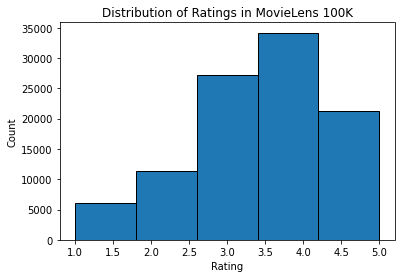

In [5]:
plt.hist(df['rating'], bins=5, ec='black')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Distribution of Ratings in MovieLens 100K')
plt.show()

In [9]:
df.describe()

,user_id,item_id,rating
count,100000.00000,100000.000000,100000.000000
mean,462.48475,425.530130,3.529860
std,266.61442,330.798356,1.125674
min,1.00000,1.000000,1.000000
25%,254.00000,175.000000,3.000000
50%,447.00000,322.000000,4.000000
75%,682.00000,631.000000,4.000000
max,943.00000,1682.000000,5.000000


/Users/dimassoares/opt/anaconda3/envs/recenv/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


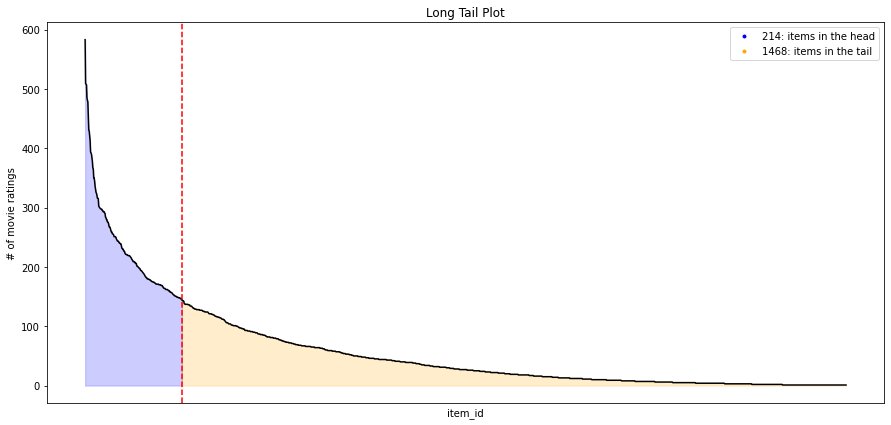

In [6]:
fig = plt.figure(figsize=(15, 7))
rm.long_tail_plot(df=df, 
             item_id_column="item_id", 
             interaction_type="movie ratings", 
             percentage=0.5,
             x_labels=False)

# Modeling SVD Modeling

In [15]:
reader = Reader(rating_scale=(0, 5))
df_surprise = Dataset.load_from_df(df, reader = reader)
train_df, test_df = train_test_split(df_surprise, test_size=0.15)

We are going to use SVD as an MF algorithm for collaborative filtering. To do so, the `surprise` library is used. 
![SVD definition](../imgs/svd_definition.png)

The documentation for the model details can be found [HERE](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD). For sake of simplicity, the documentation tutorial is followed. 

In [13]:
svd_model = SVD()

# Run 5-fold cross-validation and print results.
cv = cross_validate(svd_model, df_surprise, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9338  0.9403  0.9295  0.9424  0.9394  0.9371  0.0047  
Fit time          4.22    4.22    4.38    4.15    4.03    4.20    0.11    
Test time         0.13    0.12    0.11    0.10    0.11    0.12    0.01    


In [16]:
# fitting the model
svd_model.fit(train_df)

In [19]:
# Validating predictions 

test = svd_model.test(test_df)
test = pd.DataFrame(test)
test.drop("details", inplace=True, axis=1)
test.columns = ['user_id', 'item_id', 'rating', 'cf_predictions']
test.head()

,user_id,item_id,rating,cf_predictions
0,708,25,3.0,3.384963
1,655,223,3.0,3.327821
2,874,14,4.0,4.003579
3,518,508,3.0,3.350738
4,250,50,5.0,4.032179


In [23]:
# Making predictions 

def get_users_predictions(user_id, n, model):
    recommended_items = pd.DataFrame(model.loc[user_id])
    recommended_items.columns = ["predicted_rating"]
    recommended_items = recommended_items.sort_values('predicted_rating', ascending=False)    
    recommended_items = recommended_items.head(n)
    return recommended_items.index.tolist()

cf_model = test.pivot_table(index='user_id', columns='item_id', values='cf_predictions').fillna(0)

get_users_predictions(156, 10, cf_model)

[187, 318, 192, 211, 137, 941, 940, 939, 938, 937]

In [41]:
# defining the predictions for all users

pred_test = test.groupby('user_id', as_index=False)['item_id'].agg({'actual': (lambda x: list(set(x)))})
pred_test = pred_test.set_index("user_id")

# make recommendations for all members in the test data
cf_recs = [] = []
for user in pred_test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model)
    cf_recs.append(cf_predictions)
        
pred_test['svd_predictions'] = cf_recs
pred_test.head()

,actual,svd_predictions
user_id,,
1,"[128, 130, 4, 137, 139, 14, 270, 17, 24, 157, ...","[185, 169, 198, 137, 205, 208, 60, 14, 206, 69]"
2,"[291, 300, 111, 274, 19, 311, 281, 283, 285]","[285, 19, 283, 311, 300, 291, 111, 274, 281, 942]"
3,"[355, 328, 264, 337, 346, 348]","[346, 337, 328, 348, 355, 264, 943, 942, 941, ..."
4,"[258, 260, 357, 294, 264, 329, 301, 303]","[357, 258, 303, 301, 329, 294, 260, 264, 887, ..."
5,"[1, 388, 391, 394, 153, 412, 416, 163, 167, 42...","[427, 194, 210, 435, 1, 381, 153, 89, 234, 163]"


# Comparing models performance: SVD, PMF, NMF, Popularity

The SVD model is one version of MF algorithm that has bias correction parameters that are estimated is fit process. Although it is very popular approach, a classic model in the MF context is the PMF and it address the MF as a multiplication of two Normal distributions. The reference paper can be found [here](https://www.cs.utoronto.ca/~amnih/papers/pmf.pdf) 

## PMF

In [26]:
pmf_model = SVD(biased = False)
pmf_model.fit(train_df)

In [30]:
test_pmf = pmf_model.test(test_df)
test_pmf = pd.DataFrame(test_pmf)
test_pmf.drop("details", inplace=True, axis=1)
test_pmf.columns = ['user_id', 'item_id', 'rating', 'cf_predictions']
test_pmf.head()

,user_id,item_id,rating,cf_predictions
0,708,25,3.0,3.690360
1,655,223,3.0,2.795584
2,874,14,4.0,3.979682
3,518,508,3.0,3.724811
4,250,50,5.0,3.918482


In [42]:
# defining the predictions for all users
cf_model_pmf = test_pmf.pivot_table(index='user_id', columns='item_id', values='cf_predictions').fillna(0)

# make recommendations for all members in the test data
cf_recs = [] = []
for user in pred_test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model_pmf)
    cf_recs.append(cf_predictions)
        
pred_test['pmf_predictions'] = cf_recs
pred_test.head()

,actual,svd_predictions,pmf_predictions
user_id,,,
1,"[128, 130, 4, 137, 139, 14, 270, 17, 24, 157, ...","[185, 169, 198, 137, 205, 208, 60, 14, 206, 69]","[169, 60, 198, 4, 14, 196, 207, 203, 68, 185]"
2,"[291, 300, 111, 274, 19, 311, 281, 283, 285]","[285, 19, 283, 311, 300, 291, 111, 274, 281, 942]","[285, 19, 283, 311, 274, 111, 300, 291, 281, 942]"
3,"[355, 328, 264, 337, 346, 348]","[346, 337, 328, 348, 355, 264, 943, 942, 941, ...","[346, 337, 355, 328, 348, 264, 943, 942, 941, ..."
4,"[258, 260, 357, 294, 264, 329, 301, 303]","[357, 258, 303, 301, 329, 294, 260, 264, 887, ...","[357, 258, 303, 301, 294, 329, 264, 260, 888, ..."
5,"[1, 388, 391, 394, 153, 412, 416, 163, 167, 42...","[427, 194, 210, 435, 1, 381, 153, 89, 234, 163]","[89, 234, 210, 194, 431, 427, 1, 211, 443, 381]"


## NMF 

In [32]:
nmf_model = NMF()
nmf_model.fit(train_df)

In [33]:
test_nmf = nmf_model.test(test_df)
test_nmf = pd.DataFrame(test_nmf)
test_nmf.drop("details", inplace=True, axis=1)
test_nmf.columns = ['user_id', 'item_id', 'rating', 'cf_predictions']
test_nmf.head()

,user_id,item_id,rating,cf_predictions
0,708,25,3.0,3.461558
1,655,223,3.0,3.527311
2,874,14,4.0,4.120660
3,518,508,3.0,3.852617
4,250,50,5.0,4.299614


In [43]:
# defining the predictions for all users
cf_model_nmf = test_nmf.pivot_table(index='user_id', columns='item_id', values='cf_predictions').fillna(0)

# make recommendations for all members in the test data
cf_recs = [] = []
for user in pred_test.index:
    cf_predictions = get_users_predictions(user, 10, cf_model_nmf)
    cf_recs.append(cf_predictions)
        
pred_test['nmf_predictions'] = cf_recs
pred_test.head()

,actual,svd_predictions,pmf_predictions,nmf_predictions
user_id,,,,
1,"[128, 130, 4, 137, 139, 14, 270, 17, 24, 157, ...","[185, 169, 198, 137, 205, 208, 60, 14, 206, 69]","[169, 60, 198, 4, 14, 196, 207, 203, 68, 185]","[60, 169, 14, 185, 207, 196, 208, 137, 198, 205]"
2,"[291, 300, 111, 274, 19, 311, 281, 283, 285]","[285, 19, 283, 311, 300, 291, 111, 274, 281, 942]","[285, 19, 283, 311, 274, 111, 300, 291, 281, 942]","[19, 285, 283, 311, 111, 300, 291, 281, 274, 942]"
3,"[355, 328, 264, 337, 346, 348]","[346, 337, 328, 348, 355, 264, 943, 942, 941, ...","[346, 337, 355, 328, 348, 264, 943, 942, 941, ...","[328, 346, 337, 348, 355, 264, 943, 942, 941, ..."
4,"[258, 260, 357, 294, 264, 329, 301, 303]","[357, 258, 303, 301, 329, 294, 260, 264, 887, ...","[357, 258, 303, 301, 294, 329, 264, 260, 888, ...","[357, 303, 258, 329, 294, 301, 264, 260, 888, ..."
5,"[1, 388, 391, 394, 153, 412, 416, 163, 167, 42...","[427, 194, 210, 435, 1, 381, 153, 89, 234, 163]","[89, 234, 210, 194, 431, 427, 1, 211, 443, 381]","[427, 89, 381, 443, 435, 153, 1, 211, 234, 210]"


## Popularity Model

In [46]:
#make recommendations for all members in the test data
popularity_recs = df.item_id.value_counts().head(10).index.tolist()

pop_recs = []
for user in pred_test.index:
    pop_predictions = popularity_recs
    pop_recs.append(pop_predictions)
        
pred_test['pop_predictions'] = pop_recs
pred_test.head()

,actual,svd_predictions,pmf_predictions,nmf_predictions,pop_predictions
user_id,,,,,
1,"[128, 130, 4, 137, 139, 14, 270, 17, 24, 157, ...","[185, 169, 198, 137, 205, 208, 60, 14, 206, 69]","[169, 60, 198, 4, 14, 196, 207, 203, 68, 185]","[60, 169, 14, 185, 207, 196, 208, 137, 198, 205]","[50, 258, 100, 181, 294, 286, 288, 1, 300, 121]"
2,"[291, 300, 111, 274, 19, 311, 281, 283, 285]","[285, 19, 283, 311, 300, 291, 111, 274, 281, 942]","[285, 19, 283, 311, 274, 111, 300, 291, 281, 942]","[19, 285, 283, 311, 111, 300, 291, 281, 274, 942]","[50, 258, 100, 181, 294, 286, 288, 1, 300, 121]"
3,"[355, 328, 264, 337, 346, 348]","[346, 337, 328, 348, 355, 264, 943, 942, 941, ...","[346, 337, 355, 328, 348, 264, 943, 942, 941, ...","[328, 346, 337, 348, 355, 264, 943, 942, 941, ...","[50, 258, 100, 181, 294, 286, 288, 1, 300, 121]"
4,"[258, 260, 357, 294, 264, 329, 301, 303]","[357, 258, 303, 301, 329, 294, 260, 264, 887, ...","[357, 258, 303, 301, 294, 329, 264, 260, 888, ...","[357, 303, 258, 329, 294, 301, 264, 260, 888, ...","[50, 258, 100, 181, 294, 286, 288, 1, 300, 121]"
5,"[1, 388, 391, 394, 153, 412, 416, 163, 167, 42...","[427, 194, 210, 435, 1, 381, 153, 89, 234, 163]","[89, 234, 210, 194, 431, 427, 1, 211, 443, 381]","[427, 89, 381, 443, 435, 153, 1, 211, 234, 210]","[50, 258, 100, 181, 294, 286, 288, 1, 300, 121]"


In [56]:
pred_test['actual']

user_id
1      [128, 130, 4, 137, 139, 14, 270, 17, 24, 157, ...
2           [291, 300, 111, 274, 19, 311, 281, 283, 285]
3                         [355, 328, 264, 337, 346, 348]
4               [258, 260, 357, 294, 264, 329, 301, 303]
5      [1, 388, 391, 394, 153, 412, 416, 163, 167, 42...
                             ...                        
939    [931, 1190, 742, 680, 106, 689, 818, 274, 597,...
940    [164, 69, 70, 47, 1137, 657, 116, 436, 316, 31...
941                                                [181]
942    [705, 99, 487, 615, 71, 265, 234, 500, 216, 31...
943    [9, 12, 399, 274, 403, 1044, 22, 27, 284, 42, ...
Name: actual, Length: 938, dtype: object

In [74]:
print("RMSE SVD: ", rm.rmse(test.rating, test.cf_predictions))
print("RMSE PMF: ", rm.rmse(test_pmf.rating, test_pmf.cf_predictions))
print("RMSE NMF: ", rm.rmse(test_nmf.rating, test_nmf.cf_predictions))

RMSE SVD:  0.9430241172722802
RMSE PMF:  0.9430241172722802
RMSE NMF:  0.9647452437020301


## MarK comparison

In [ ]:
actual = test.actual.values.tolist()
cf_predictions = test.cf_predictions.values.tolist()
pop_predictions = test.pop_predictions.values.tolist()
random_predictions = test.random_predictions.values.tolist()

In [89]:
def mark_generation(K, actual_values, predictions_values):
    pop_mark = []
    for k in np.arange(1, K+1):
        pop_mark.extend([rm.mark(actual_values, predictions_values, k=k)])
    return pop_mark

In [99]:
actual = actual = pred_test.actual.values.tolist()
svd_predictions = pred_test.svd_predictions.values.tolist()
pmf_predictions = pred_test.pmf_predictions.values.tolist()
nmf_predictions = pred_test.nmf_predictions.values.tolist()
pop_predictions = pred_test.pop_predictions.values.tolist()


mark_scores = []
for pred_model in [svd_predictions, pmf_predictions, nmf_predictions, pop_predictions]:
    mark_scores.append(mark_generation(10, actual, pred_model))

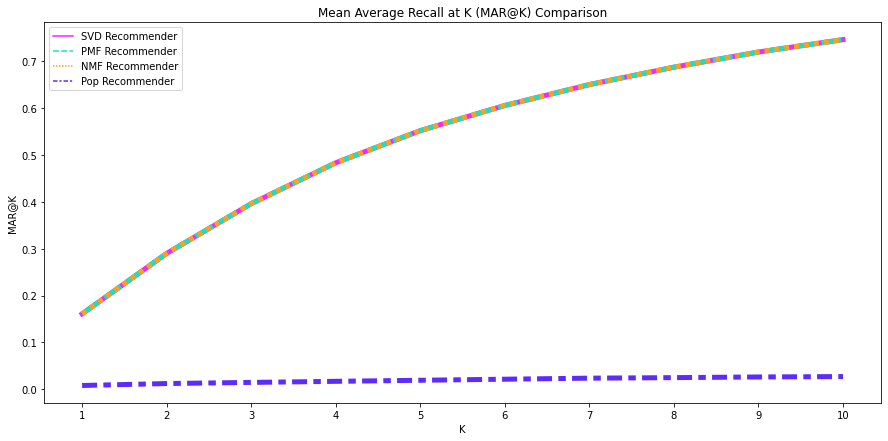

In [101]:
index = range(1,10+1)
names = ['SVD Recommender', 'PMF Recommender', 'NMF Recommender', 'Pop Recommender']

fig = plt.figure(figsize=(15, 7))
rm.mark_plot(mark_scores, model_names=names, k_range=index)